In [1]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy

""
from qcal.modelconstruction.single_qubit_models import *
from qcal.modelconstruction.experiment_design import *
from qcal.phase_estimation.analysis import *

import plotly.io as pio
pio.renderers.default = 'jupyterlab'

pd.set_option('display.max_columns', None)

logging.basicConfig(level=logging.INFO)

%load_ext autoreload
%autoreload 2

In [2]:
depths = [2**i for i in range(10)]
edesign = EDesign_1QXZ(depths, 'Q0')

In [3]:
error_vec = np.array([0.01, 0.01, 0.01])
error_model = create_XZ_model_1q(error_vec)
target_model = create_XZ_model_1q(np.array([0.0, 0.0, 0.0]))

In [4]:
ds = edesign.make_dataset(error_model, 1000)

In [5]:
estimate_phase(ds, edesign, 'Gxpi2', '1', '0', '0', '1')

(array([4.68839359, 4.70438966, 4.69987439, 4.70363578, 4.69983382,
        4.70147939, 4.70234697, 4.70235542, 4.70229075, 4.70236744]),
 9)

In [6]:
analysis = Analysis_1QXZ(ds, edesign)
print(analysis)

Estimates: {'Gxpi2': array([4.68839359, 4.70438966, 4.69987439, 4.70363578, 4.69983382,
       4.70147939, 4.70234697, 4.70235542, 4.70229075, 4.70236744]), 'Gxpi2.Gzpi2.Gzpi2.Gxpi2.Gzpi2.Gzpi2': array([0.08198018, 6.25920371, 6.26206633, 6.25262516, 6.25389326,
       6.24088265, 6.23686567, 6.2367578 , 6.23657625, 6.23698485]), 'Gxpi2.Gxpi2.Gzpi2.Gzpi2': array([3.16558805, 3.12959496, 3.15060678, 3.15509412, 3.1544653 ,
       3.15288552, 3.15375078, 3.15388012, 3.15405186, 3.15395464])},
 Last Good Index: {'Gxpi2': 9, 'Gxpi2.Gzpi2.Gzpi2.Gxpi2.Gzpi2.Gzpi2': 9, 'Gxpi2.Gxpi2.Gzpi2.Gzpi2': 9}


# run on device

In [7]:
import qcal.settings as settings

from qcal.config import Config
from qcal.managers.classification_manager import ClassificationManager
from qcal.math.utils import round_to_order_error
from qcal.qpu.qpu import QPU

import logging

from collections.abc import Iterable
from IPython.display import clear_output
from numpy.typing import NDArray
from typing import Any, Callable, Dict, List, Tuple

import qcal as qc
import qcal.backend.qubic.transpiler as qbt
from qcal.units import *
from qcal.utils import load_from_pickle
from qcal.backend.qubic.qpu import QubicQPU

In [8]:
def RPE_Experiment_1QXZ(
        qpu:             QPU,
        config:          Config,
        qubit_label:     int,
        edesign:         ExperimentDesign,
        compiler:        Any | None = None,
        transpiler:      Any | None = None,
        classifier:      ClassificationManager = None,
        n_shots:         int = 1024,
        n_batches:       int = 1,
        n_circs_per_seq: int = 1,
        raster_circuits: bool = False,
        **kwargs
    ) -> Callable:
    """Robust Phase Estimation.

    This protocol requires a valid pyGSTi and pyRPE installation.

    Args:
        qpu (QPU): custom QPU object.
        config (Config): qcal Config object.
        qubit_labels (Iterable[int]): a list specifying sets of system labels 
            on which to perform RPE for a given gate.
        experiment (str): type of RPE experiment.
        circuit_depths (List[int]): a list of positive integers specifying the 
            circuit depths.
        compiler (Any | Compiler | None, optional): custom compiler to compile
            the True-Q circuits. Defaults to None.
        transpiler (Any | None, optional): custom transpiler to transpile
            the True-Q circuits to experimental circuits. Defaults to None.
        classifier (ClassificationManager, optional): manager used for 
            classifying raw data. Defaults to None.
        n_shots (int, optional): number of measurements per circuit. 
                Defaults to 1024.
        n_batches (int, optional): number of batches of measurements. Defaults
            to 1.
        n_circs_per_seq (int, optional): maximum number of circuits that can be
            measured per sequence. Defaults to 1.
        raster_circuits (bool, optional): whether to raster through all
            circuits in a batch during measurement. Defaults to False. By
            default, all circuits in a batch will be measured n_shots times
            one by one. If True, all circuits in a batch will be measured
            back-to-back one shot at a time. This can help average out the 
            effects of drift on the timescale of a measurement.

    Returns:
        Callable: RPE class instance.
    """

    class RPE_Experiment_1QXZ(qpu):
        """pyRPE protocol."""

        def __init__(self,
                config:          Config,
                qubit_label:     int,
                edesign:         ExperimentDesign,
                compiler:        Any | None = None,
                transpiler:      Any | None = None,
                classifier:      ClassificationManager = None,
                n_shots:         int = 1024,
                n_batches:       int = 1,
                n_circs_per_seq: int = 1,
                raster_circuits: bool = False,
                **kwargs
            ) -> None:
            from qcal.interface.pygsti.transpiler import Transpiler

            try:
                import pygsti
                from pygsti.modelpacks import smq2Q_XXYYII
                from pygsti.modelpacks import smq2Q_XYICPHASE
                logger.info(f" pyGSTi version: {pygsti.__version__}\n")
            except ImportError:
                logger.warning(' Unable to import pyGSTi!')

            self._config = config
            self._qubit_labels = [qubit_label]
            self._edesign = edesign
            self._qubits = [qubit_label]
            self._n_shots = n_shots


            self._pygsti_circuits = edesign.circuit_list

            
            
            if transpiler is None:
                transpiler = Transpiler()

            qpu.__init__(self,
                config=config, 
                compiler=compiler, 
                transpiler=transpiler,
                classifier=classifier,
                n_shots=n_shots, 
                n_batches=n_batches, 
                n_circs_per_seq=n_circs_per_seq, 
                raster_circuits=raster_circuits,
                **kwargs
            )
            self._circuits = self.generate_circuits()

        def generate_circuits(self):
            """Generate all RPE circuits."""
            from qcal.interface.pygsti.circuits import load_circuits

            logger.info(' Generating circuits from pyGSTi...')
            self._circuits = load_circuits(self._pygsti_circuits)

        def generate_pygsti_dataset(self):
            """Generate a pyGSTi dataset for each qubit label."""
            logger.info(' Generating pyGSTi reports...')
            
            circuits = self._transpiled_circuits
            fileloc = self.data_manager.save_path
            for ql in self._qubit_labels:
                if isinstance(ql, Iterable):
                    q_index = tuple([self._qubits.index(q) for q in ql])
                    qs = ''.join(str(q) for q in ql)
                else:
                    q_index = tuple([self._qubits.index(ql)])
                    qs = str(ql)

                results_dfs = []
                for i, circuit in enumerate(circuits):
                    results_dfs.append(
                        pd.DataFrame(
                            [circuit.results.marginalize(q_index).dict], 
                            index=[circuits['pygsti_circuit'][i]]
                        )
                    )
                results_df = pd.concat(results_dfs)
                results_df = results_df.fillna(0).astype(int).rename(
                    columns=lambda col: col + ' count'
                )
                self._df = results_df

                with open(f'{fileloc}dataset_{qs}.txt', 'w') as f:
                    f.write(
                        '## Columns = ' + ', '.join(results_df.columns) + "\n"
                    )
                    f.close()
                results_df.to_csv(
                    f'{fileloc}dataset_{qs}.txt', 
                    sep=' ', 
                    mode='a', 
                    header=False
                )

        def run(self):
            """Run all experimental methods and analyze results."""
            self.generate_circuits()
            qpu.run(self, self._circuits, save=False)
            self.save()
            self.generate_pygsti_dataset()
            
    return RPE_Experiment_1QXZ(
        config,
        qubit_label,
        edesign,       
        compiler,      
        transpiler,    
        classifier,    
        n_shots,       
        n_batches,     
        n_circs_per_seq,
        raster_circuits,
        **kwargs
    )

In [9]:
import qcal.settings as settings

logger = logging.getLogger(__name__)

basedir = '/home/jpmarceaux/experiment/'
settings.Settings.config_path = basedir + 'config/'
settings.Settings.data_path = basedir + 'data/'
settings.Settings.save_data = True



#cfg = qc.Config()
cfg = qc.Config(basedir + 'config/configs/X6Y3/config.yaml')
classifier = load_from_pickle(basedir + 'config/configs/X6Y3/ClassificationManager.pkl')
# cfg = qc.Config(basedir + 'config/Campbell06/X6Y3/config_abhi.yaml')
cfg.draw_qpu()

In [10]:
qid = 'Q5'
depths = [2**i for i in range(10)]
n_shots = 512
edesign = EDesign_1QXZ(depths, qid)

In [11]:
rpe_exp = RPE_Experiment_1QXZ(QubicQPU, cfg,int(qid[1]), edesign, 
    classifier=classifier,
    n_shots=512,
    n_circs_per_seq=100,
    reload_pulse=False,
    reload_freq=False,
    reload_env=False,
    zero_between_reload=False
)

INFO:__main__: pyGSTi version: 0.9.12.2



INFO:__main__: Generating circuits from pyGSTi...


In [12]:
rpe_exp.run()

INFO:QPU: Data save location: /home/jpmarceaux/experiment/data/2024-10-22/20241022_171339/

INFO:__main__: Generating pyGSTi reports...


Runtime:   Compile  Transpile  Sequencing  Write  Measure  Process  Total
Time (s)      0.0        0.2         1.8    0.0     32.4      0.1   34.5



In [13]:
ds_exp = pygsti.io.read_dataset(rpe_exp.data_manager.save_path + 'dataset_5.txt')

Reading /home/jpmarceaux/experiment/data/2024-10-22/20241022_171339/dataset_5.txt: 100%


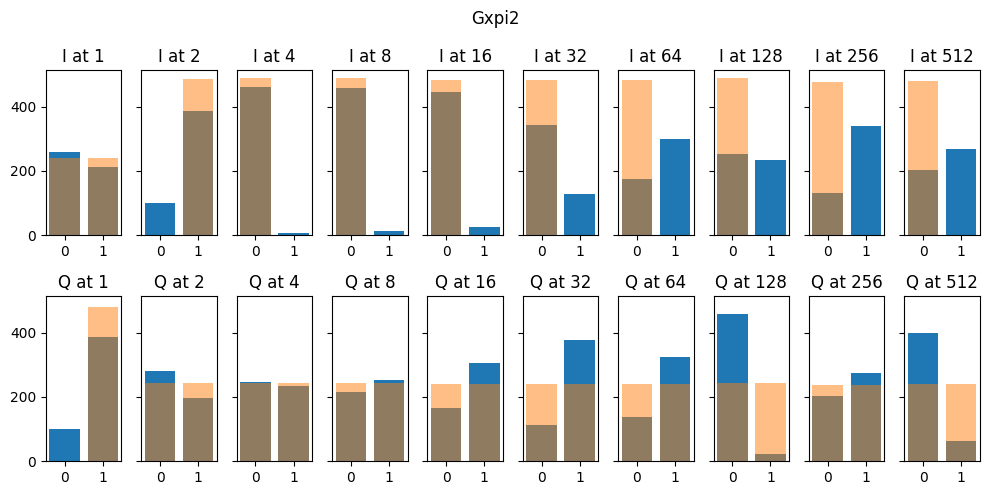

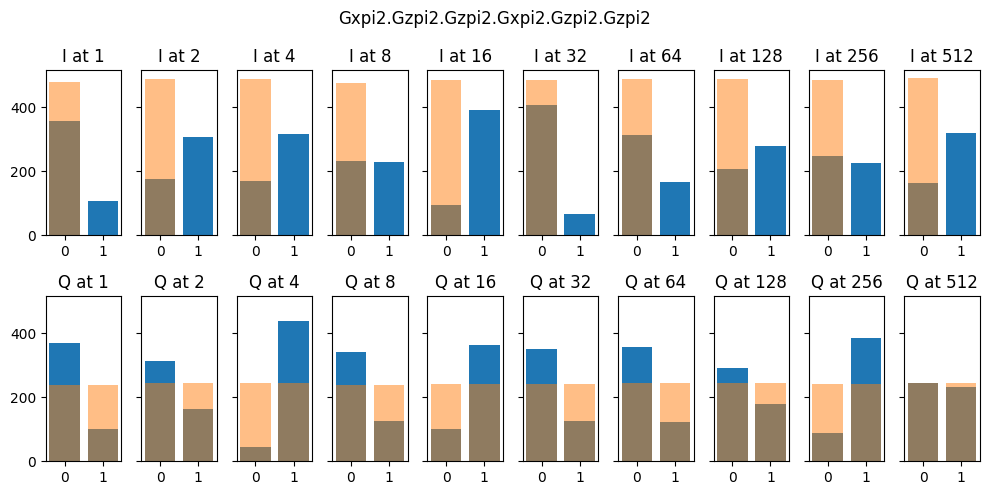

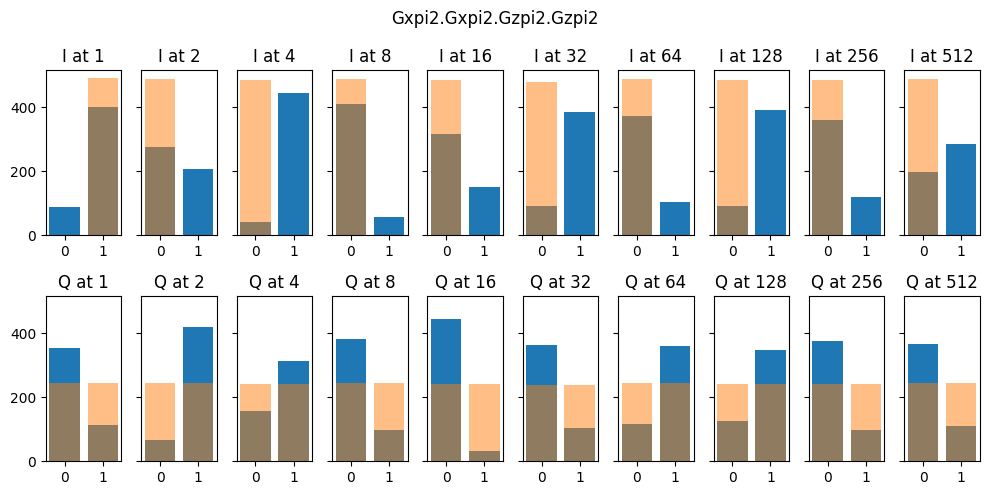

In [14]:
target_model = create_XZ_model_1q(np.array([0.0, 0.0, 0.0]), qid=qid)
edesign.plot_dataset(ds_exp, target_model)

In [168]:
analysis = Analysis_1QXZ(ds_exp, edesign)
print(analysis)

Estimates: {'Gxpi2': array([5.1374882 , 4.49777892, 4.73106628, 4.71238898, 4.69961412,
       4.69617133, 4.69427959, 4.68443314, 4.68902408, 4.68887564]), 'Gxpi2.Gzpi2.Gzpi2.Gxpi2.Gzpi2.Gzpi2': array([0.83338042, 0.94626204, 1.04636806, 0.9370869 , 0.9928491 ,
       0.97256184, 0.96601526, 0.96315487, 0.95971379, 0.95739015]), 'Gxpi2.Gxpi2.Gzpi2.Gzpi2': array([2.28764003, 2.54333004, 2.46555291, 2.45298692, 2.45453298,
       2.46099094, 2.46052522, 2.46825826, 2.45838516, 2.4586817 ])},
 Last Good Index: {'Gxpi2': 9, 'Gxpi2.Gzpi2.Gzpi2.Gxpi2.Gzpi2.Gzpi2': 9, 'Gxpi2.Gxpi2.Gzpi2.Gzpi2': 7}
